# Model 5: Transfer learning model with denoised images and augmentation

This model utilizes transfer learning and the functional Keras API to produce a mixed convolutional model on denoised images. Because of imbalance, the melanoma images are augmented. A dropout layer and L2 regularization were included to prevent overfitting. The model utilizes the [Xception](https://keras.io/api/applications/xception/) architecture, trained on the famous [ImageNet](https://image-net.org/) image database.

In [1]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Concatenate, Conv2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.metrics import AUC, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import time

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
meta = pd.read_csv('../processed_data/train.csv', index_col=0)
meta.head()

,age_approx,Unknown,female,male,head/neck,lower extremity,oral/genital,palms/soles,torso,upper extremity,target
0,45.0,0,0,1,1,0,0,0,0,0,0
1,45.0,0,1,0,0,0,0,0,0,1,0
2,50.0,0,1,0,0,1,0,0,0,0,0
3,45.0,0,1,0,1,0,0,0,0,0,0
4,55.0,0,1,0,0,0,0,0,0,1,0


### Metadata

In [48]:
y = meta['target'].values.reshape(-1,1)
X = meta.drop('target', axis=1)
meta_train, meta_test, y_train, y_test = train_test_split(X, y, test_size=0.3 ,random_state=867_5309, stratify=y)

In [49]:
meta_train = meta_train.astype('ushort')
meta_test = meta_test.astype('ushort')

In [50]:
meta_train.shape

(23188, 10)

In [51]:
y_train.shape

(23188, 1)

### Image data

In [52]:
PATH = '../processed_data/processed_train_img_array.pkl'
with open(PATH, 'rb') as file:
    img_array = pickle.load(file)
img_array = img_array.astype('ushort')
img_train, img_test, _1, _2 = train_test_split(img_array, y, test_size=0.3, stratify=y, random_state=867_5309) # Should split exactly the same as above

In [53]:
img_train.shape

(23188, 80, 120, 3)

In [54]:
img_test.shape

(9938, 80, 120, 3)

### Augmentation

In [55]:
# Prepare augmentation files
augmentation_files = pd.read_csv('../data/train.csv', usecols=['image_name'])
augmentation_files = pd.concat([augmentation_files,meta], axis=1)
augmentation_files = augmentation_files[augmentation_files['target'] == 1]
augmentation_files['index'] = range(len(augmentation_files))

raw_files_path = '../data/jpeg/train/'
augmentation_files['image_name'] = augmentation_files['image_name'].map(lambda x: raw_files_path+x+'.jpg')

In [177]:
# Instantiate data generator
aug = ImageDataGenerator(rotation_range=270,
                        height_shift_range=1,
                        width_shift_range=1,
                        brightness_range=[3.3,3.9],
                        channel_shift_range=150.0,
                        horizontal_flip=True,
                        vertical_flip=True,
                        shear_range=125.0)

In [225]:
ITERATIONS = 3
SEED = 867_5309
aug.fit(img_train)
img_generator = aug.flow_from_dataframe(dataframe=augmentation_files,
                                        x_col='image_name',
                                        y_col='index',
                                        class_mode='raw',
                                        shuffle=False,
                                        target_size=img_train.shape[1:3],
                                        seed=SEED
                                       )

# Augment data additional 
img_y = np.empty((1,1))
iteration = 0
for x_batch in img_generator:
    iteration += 1
    img_train = np.concatenate((img_train, x_batch[0]), axis=0)
    img_y = np.concatenate((img_y, x_batch[1].reshape(-1,1)), axis=0)
    print(f'Batch {iteration} completed.')
    if iteration == ITERATIONS:
        break
    SEED += 1
img_y = img_y[1:]

Found 584 validated image filenames.
Batch 1 completed.
Batch 2 completed.
Batch 3 completed.


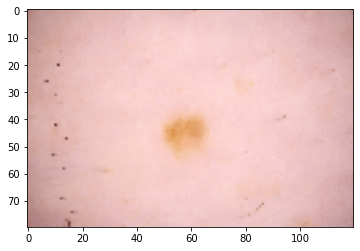

In [264]:
import matplotlib.pyplot as plt
augs = img_train[:-584]
sample = np.random.randint(0,583)
plt.imshow(augs[sample]/255)
# print(img_y[sample])

In [13]:
# Join metadata
new_metadata = pd.DataFrame(img_y, columns=['index']).astype('int')
new_metadata = pd.merge(new_metadata,augmentation_files,
                        on='index',
                        how='left',
                        validate='many_to_many')[meta.columns]

meta_train = pd.concat([meta_train, new_metadata.drop('target', axis=1)])
y_train = np.concatenate([y_train, new_metadata['target'].values.reshape(-1,1)])

### Model

In [14]:
LEARNING_RATE = 0.001
recall = Recall(name='recall')

# Define inputs
meta_inputs = Input(shape=(10,))
img_inputs = Input(shape=(80,120,3,))

# Model 1
meta_model = Dense(4, activation='relu')(meta_inputs)
meta_model = Dense(4, activation='relu')(meta_model)

# Model 2
img_model = Xception(include_top=False, input_shape=(80,120,3,))(img_inputs)
img_model = Conv2D(8, kernel_size=(5,5),
                         padding='same',
                         activation='relu')(img_model)
img_model = GlobalAveragePooling2D()(img_model)
img_model = Dropout(rate=0.35)(img_model)

# Merge models
merged_model = Concatenate()([meta_model, img_model])
merged_model = Dense(4, activation='relu',
                     kernel_regularizer=l2(l=0.04))(merged_model)
merged_output = Dense(1, activation='sigmoid')(merged_model)


# Define functional model
model = Model(inputs=[meta_inputs, img_inputs], outputs=merged_output)

# Compile model
auc = AUC(name = 'auc')
model.compile(Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=[auc, recall])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 80, 120, 3)] 0                                            
__________________________________________________________________________________________________
xception (Functional)           (None, 3, 4, 2048)   20861480    input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 3, 4, 8)      409608      xception[0][0]                   
______________________________________________________________________________________________

See `fchollet`'s discussion of class weights [here](https://keras.io/examples/structured_data/imbalanced_classification/).

In [15]:
weight_for_0 = 1.0 / ((len(y_train)-y_train.sum())/len(y_train))
weight_for_1 = 1.0 / (y_train.sum()/len(y_train))
class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 1.070635234206945, 1: 15.157240522063391}

In [16]:
EPOCHS = 10
BATCH_SIZE = 10

In [17]:
# for reproducibility, we will set a seed
np.random.seed(1)
tf.random.set_seed(2)

history = model.fit(x = [meta_train, img_train], y = y_train,
                    class_weight=class_weight,
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data=([meta_test, img_test], y_test))

Epoch 1/10
2439/2439 [==============================] - 155s 60ms/step - loss: 2.3499 - auc: 0.7291 - recall: 0.5956 - val_loss: 0.4778 - val_auc: 0.7310 - val_recall: 0.3886
Epoch 2/10
2439/2439 [==============================] - 145s 60ms/step - loss: 0.9370 - auc: 0.8842 - recall: 0.7808 - val_loss: 0.4523 - val_auc: 0.7930 - val_recall: 0.3429
Epoch 3/10
2439/2439 [==============================] - 145s 60ms/step - loss: 0.7827 - auc: 0.9128 - recall: 0.7492 - val_loss: 0.3060 - val_auc: 0.8204 - val_recall: 0.2286
Epoch 4/10
2439/2439 [==============================] - 145s 59ms/step - loss: 0.7106 - auc: 0.9314 - recall: 0.8245 - val_loss: 0.2963 - val_auc: 0.7804 - val_recall: 0.2857
Epoch 5/10
2439/2439 [==============================] - 145s 59ms/step - loss: 0.6787 - auc: 0.9323 - recall: 0.8252 - val_loss: 0.3347 - val_auc: 0.8009 - val_recall: 0.4457
Epoch 6/10
2439/2439 [==============================] - 145s 60ms/step - loss: 0.6427 - auc: 0.9355 - recall: 0.8121 - val_lo

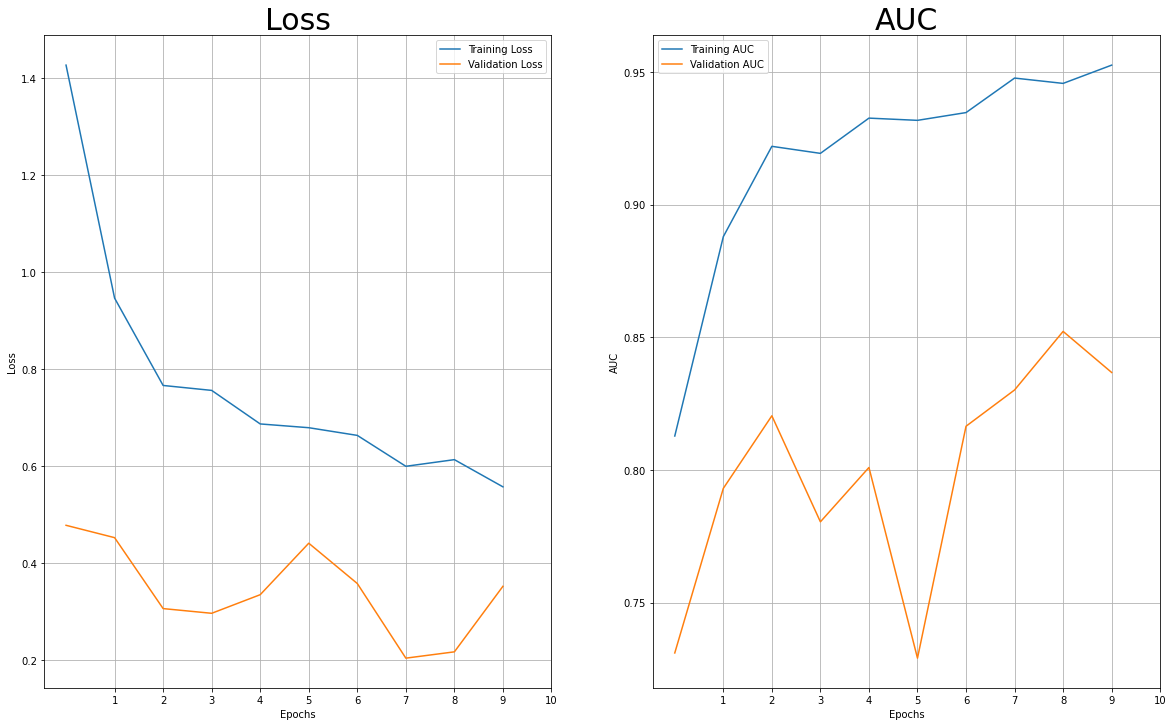

In [18]:
X = np.arange(0, EPOCHS)

plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(X, history.history['loss'], label = 'Training Loss')
plt.plot(X, history.history['val_loss'], label = 'Validation Loss')
plt.grid(True)
plt.xticks(X+1)
plt.legend()
plt.title('Loss', fontsize=30)

plt.subplot(1,2,2)
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.plot(X, history.history['auc'], label = 'Training AUC')
plt.plot(X, history.history['val_auc'], label = 'Validation AUC')
plt.grid(True)
plt.xticks(X+1)
plt.legend()
_ = plt.title('AUC', fontsize=30)

In [19]:
y_pred = model.predict([meta_test, img_test])
y_pred = np.array([int(i) for i in y_pred > 0.5])
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.85      0.92      9763
           1       0.07      0.62      0.13       175

    accuracy                           0.85      9938
   macro avg       0.53      0.74      0.52      9938
weighted avg       0.98      0.85      0.90      9938

